### This notebook contains the experiment code for the paper “Earliest Completion Scheduling of Contract Algorithms with End Guarantees” published in IJCAI'19.

In [1]:
import matplotlib.pyplot as plt
import math

In [22]:
def compute_r(n):
    '''
    Compute rho_n for a given n.
    
    rho_n := n*((n+1) / n) ^ (n+1).
    '''
    ans = n * 1.0
    for i in range(n+1):
        ans = ans * (n+1) / (n)
    return ans

In [23]:
def compute_a_b(n, r, maxM):
    '''
    Compute coefficients a_i and b_i using Equation (6) and (7).
    '''
    a = [1.0] * n
    b = [0.0] * n
    for i in range(n, maxM + 1):
        s = 0
        for j in range(0, n):
            t = 1.0
            for k in range(0, j):
                t = t * (b[i-n+k]+1)
            s += a[i-n+j] * t

        p = 1
        for k in range(0, n):
            p = p * (b[i-n+k] + 1)

        a.append(s / (r- p))
        b.append(p / (r- p))
    return a, b

In [25]:
def check_monotonicity_of_a():
    '''
    Verify monotonicity of a_i for n = 1..1000.
    '''
    for n in range(1, 1001):
        a, b = compute_a_b(n, compute_r(n), 100)
        l = len(a)
        for i in range(1, l-1):
            if (a[i] < a[i+1]):
                print("[WRONG] a is not monotone for n = %d, we have a[%d] >= a[%d] !" %(n, i, i+1))
                return False
    return True

check_monotonicity_of_a()

True

In [47]:
def compute_max_reach(a, tau, m):
    return tau / a[m-1]

def compute_d_star(n, L, tau):
    '''
    Compute d*(L).
    '''
    r = compute_rho(n)
    maxM = 10000
    a, b = compute_a_b(n, r, maxM)
    m_star = -1
    for m in range(n, maxM + 1):
        max_reach = compute_max_reach(a, tau, m)
        if (max_reach >= L):
            m_star = m
            break

    if (m_star == -1):
        print("m* doesn't exist.")
        return -1

    s = 1.0 * n
    for j in range(n, m_star):
        t = 1.0
        for k in range(n, j):
            t = t * (b[k] + 1)
        s += a[j] * t

    return s * L

In [48]:
def simulate(n, tau, maxB):
    '''
    Simulation
    '''
    r = compute_r(n)
    maxM = 1000
    a, b = compute_a_b(n, r, maxM)
    cost = [0]*(maxB+1)
    last = 0
    for m in range(n, maxM+1):

        s = 1.0 * n 
        for j in range(n, m):
            t = 1.0
            for k in range(n, j):
                t = t * (b[k]+1)
            s += a[j] * t

        max_reach = tau / a[m-1]

        while (last + 1 <= max_reach):
            last = last + 1
            if (last <= maxB):
                cost[last] = s * last
            else:
                return cost
        last = (int)(math.floor(max_reach))
    return cost

In [52]:
def doubling(n, maxB):
    '''
    Compute the cost of doubling strategy.
    '''
    x = [0.0, 1.0]
    cost = [0] * (1+ maxB)
    xi = 1.0
    T = 1.0
    for i in range(2, n+1):
        xi = xi * (n+1)/ n
        T += xi
    cost[1] = T
    L = 1
    x = 1.0 * (n+1) / n
    xi = xi * (n+1) / n
    T += xi
    while (L + 1 <= maxB):
        L = L + 1
        if (L > x):
            x = x * (n+1) / n
            xi = xi * (n+1) / n
            T += xi
        cost[L] = T
    return cost

def get_doubling_cost(n, L):
    b = 1.0 * (n+1) / n
    m = (int)(math.ceil(math.log(L) / math.log(b) + n))
    return ((b ** m) - 1.0) / (b - 1) 

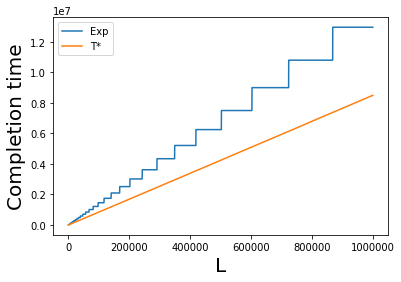

In [50]:
def exp1(maxB = 1000000):
    '''
    Completion times T∗(L) and T_exp(L) as function of L for n = 5.
    '''
    n = 5
    r = compute_r(n)
    cost_doubling  = doubling(n, maxB)
    cost_5 = simulate(5, 1, maxB)
    fig = plt.figure() 
    x = list(range(maxB+1))
    # plt.plot(x, cost_1, label="n = 1")
    plt.plot(x, cost_doubling, label="Exp")
    plt.plot(x, cost_5, label="T*")

    plt.legend(loc ='upper left')
    plt.xlabel('L',fontsize = 20)
    plt.ylabel('Completion time', fontsize = 20)
    plt.show()

exp1()

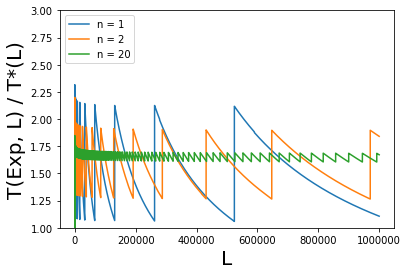

In [51]:
def exp2(maxB = 1000000):
    '''
    Ratio Texp(L)/T∗(L) as function of L.
    '''
    cost_1 = simulate(1, 1, maxB)
    cost_2 = simulate(2, 1, maxB)
    cost_20 = simulate(20, 1, maxB)
    d_1  = doubling(1, maxB)
    d_2  = doubling(2, maxB)
    d_20  = doubling(20, maxB)
    r_1 = [d_1[i] / cost_1[i] for i in range(1, maxB+1)]
    r_2 = [d_2[i] / cost_2[i] for i in range(1, maxB+1)]
    r_20 = [d_20[i] / cost_20[i] for i in range(1, maxB+1)]

    fig = plt.figure() 
    x = list(range(1, maxB+1))
    plt.plot(x, r_1, label="n = 1")
    plt.plot(x, r_2, label="n = 2")
    plt.plot(x, r_20, label="n = 20")
    plt.ylim(1,3)
    plt.legend(loc ='upper left')
    plt.xlabel('L', fontsize = 20)
    plt.ylabel('T(Exp, L) / T*(L)', fontsize = 20)
    plt.show()

exp2()

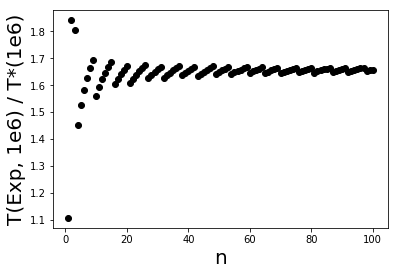

In [53]:
def exp3(L = 1000000):
    '''
    Ratio Texp(L)/T∗(L), for L = 106.
    '''
    ratio = []
    for n in range(1, 101):
        cost_doubling = get_doubling_cost(n, L)
        # cost = 1
        cost = compute_d_star(n, L, 1)
        ratio.append(cost_doubling / cost)
        # print(n, cost_doubling / cost)

    fig = plt.figure() 
    x = list(range(1, 101))
    plt.plot(x, ratio, 'o', color='black')
    # plt.ylim(1,3)
    plt.legend(loc ='upper left')
    plt.xlabel('n', fontsize = 20)
    plt.ylabel('T(Exp, 1e6) / T*(1e6)', fontsize = 20)
    plt.show()
    
exp3()